**Name:** Alireza Dehghanpour

**Student ID:** 98101555

In this practical assignment, we will develope a U-Net for semantis segmentation of lung CT-scans.

For this task, you will use a dataset consisting of CT-scans from lungs of COVID-19 patients. The regions affected by COVID-19 are marked with labels of ground glass opacity. You will be training and testing the U-Net model on this dataset.

## Imports

In [2]:
# Import any needed packages here
import torch
import numpy as np
from matplotlib import pyplot as plt

## Prepare Data
Now download and unzip the data. (Note: If you face any problems for downloading uzing gdown and unzipping, you may also download the data manually using the Goggle Drive links in the code)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
from zipfile import ZipFile
import os
import numpy as np
import gdown

# output = 'images.zip'
# url= "https://drive.google.com/file/d/1UYI8pNkuFqcOyQtnsMMXwbh92GuiMIfo/view?usp=sharing"
# gdown.download(url, output, quiet=True, fuzzy=True)
# output = 'masks.zip'
# url= "https://drive.google.com/file/d/1mYB32-cZwZEUyHogNZv-Y4eaPbRxXaHt/view?usp=sharing"
# gdown.download(url, output, quiet=True)

In [5]:
import zipfile

PATH = "/content/drive/MyDrive/"
zip_ref = zipfile.ZipFile(PATH + "images.zip", "r")
zip_ref.extractall()
zip_ref.close()

zip_ref = zipfile.ZipFile(PATH + "masks.zip", "r")
zip_ref.extractall()
zip_ref.close()
images = np.load('images_medseg.npy').astype(np.float32)
masks = np.load('masks_medseg.npy').astype(np.float32)

In [6]:
print("Images Shape:", images.shape)
print("Masks Shape:", masks.shape)

Images Shape: (100, 512, 512, 1)
Masks Shape: (100, 512, 512, 4)


The dataset consists of 100 CT images with size 512*512. In the Masks data,for each image 4 masks are provided with different meanings. The first mask (index 0) is the ground glass opacity class, indicating the regions affected by COVID-19. Also, the last mask (index 4) is the background class.

You can see the visulaiztion of a few of the CT images, and their given masks using the code below. In this assignment, use the first mask (ground glass opacity) for the segmentation task (You may also test it on other classes if you like too!)

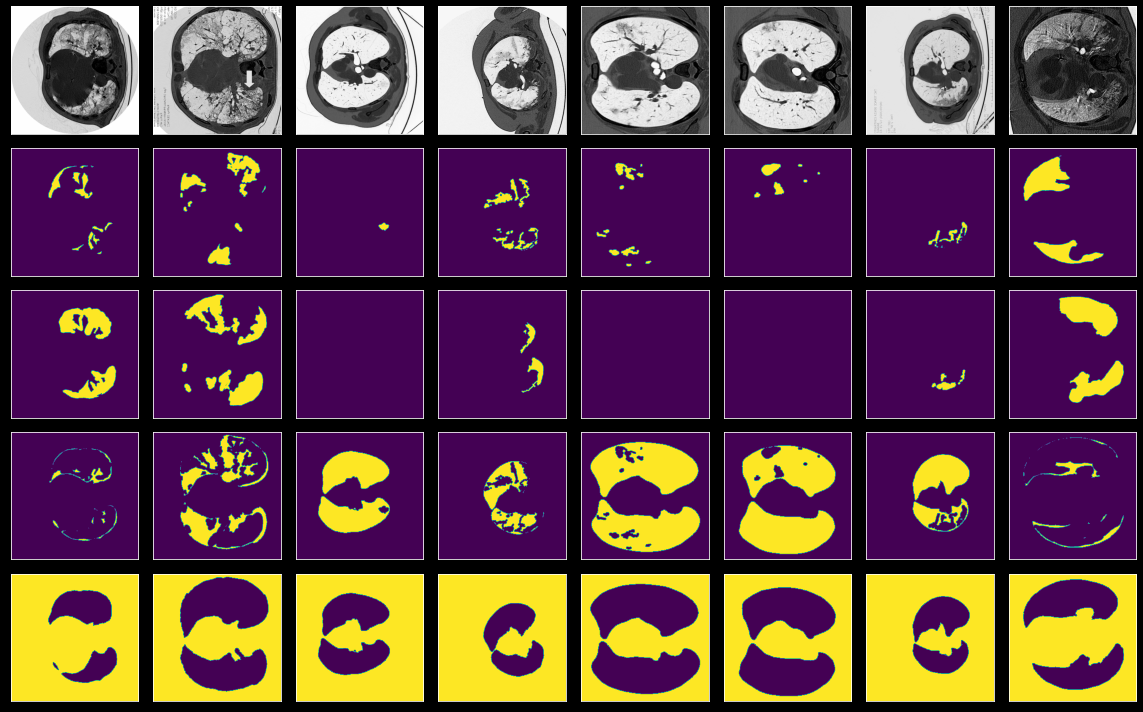

In [7]:
import matplotlib.pyplot as plt

plt.style.use("dark_background")

def visualize(image_batch, mask_batch=None, pred_batch=None, num_samples=8):
    num_classes = mask_batch.shape[-1] if mask_batch is not None else 0
    fix, ax = plt.subplots(num_classes + 1, num_samples, figsize=(num_samples * 2, (num_classes + 1) * 2))
    for i in range(num_samples):
        ax_image = ax[0, i] if num_classes > 0 else ax[i]
        ax_image.imshow(image_batch[i,:,:,0], cmap="Greys")
        ax_image.set_xticks([]) 
        ax_image.set_yticks([])
        
        if mask_batch is not None:
            for j in range(num_classes):
                if pred_batch is None:
                    #print(j)
                    mask_to_show = mask_batch[i,:,:,j]
                else:
                    mask_to_show = np.zeros(shape=(*mask_batch.shape[1:-1], 3)) 
                    mask_to_show[..., 0] = pred_batch[i,:,:,j] > 0.5
                    mask_to_show[..., 1] = mask_batch[i,:,:,j]
                ax[j + 1, i].imshow(mask_to_show, vmin=0, vmax=1)
                ax[j + 1, i].set_xticks([]) 
                ax[j + 1, i].set_yticks([]) 

    plt.tight_layout()
    plt.show()


visualize(images, masks)

## Create Your Dataset Class (10%)

In [8]:
import torch
from torchvision import transforms

class Dataset(torch.utils.data.Dataset):

  def __init__(self, data_dir, transform=None, images=None, masks=None):
    self.data_dir = data_dir
    self.images = images
    self.masks = masks
    self.transform = transform
    self.mask_transform = transform = transforms.Compose([transforms.ToTensor(),
                                                          transforms.Resize((256, 256))])

  def __len__(self):
    return len(self.images)

  def __getitem__(self, idx):
    image = self.images[idx]
    mask = self.masks[idx]
    mask = mask.astype(np.float32)
    image = image.astype(np.float32)
    if self.transform:
      image = self.transform(image)
      mask = self.mask_transform(mask)
    return image, mask

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((256, 256)),
    transforms.Normalize((0.5,), (0.5,)),
])

dataset = Dataset(None, images=images, masks=masks, transform=transform)

## Split Dataset and Dataloader (5%)

In this part, split the dataset (80% train, 10% validation, 10% test). Then, create your train and validation DataLoader, using random shuffle and batch size of 4.

In [9]:
from torch.utils.data import random_split
from torch.utils.data import DataLoader

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
test_size = int(0.5 * len(val_dataset))
val_size = len(val_dataset) - test_size
val_dataset, test_dataset = random_split(val_dataset, [val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle = True)

## Implement your U-Net (45%)

In this section implement your U-Net model, inherited from torch.nn.Module.

In the next text cell, explain the architecture of the implemented U-Net. Then, complete the code cell to creat your class.

Explain Here:
At first I define two type of blocks, the first one is down-convolution and second one is up-convolution.

The down-convolution block is a simple convolution block which is some CNN layers with BatchNorm and MaxPool.

The up-convolution block is same as down-convolution but is has ConvTranspose2d instead of MaxPool.

I used 4 down and up convolution block and there is connection between each down and up blcok. At each up-conv block we concat the corresponding down-conv feature map with the input. 

In [10]:
import torch.nn as nn
import torch.nn.functional as F


class UNet(nn.Module):
    def __init__(self, channels_in, num_classes):
        super(UNet, self).__init__()

        self.down_conv1 = DownConv(channels_in, 32)
        self.down_conv2 = DownConv(32, 64)
        self.down_conv3 = DownConv(64, 128)
        self.down_conv4 = DownConv(128, 256)

        self.middle_layer = nn.Sequential(
            nn.Dropout(0.5),
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(), 
            nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)   
        )

        self.up_conv1 = UpConv(512, 256)
        self.up_conv2 = UpConv(256, 128)
        self.up_conv3 = UpConv(128, 64)
        self.up_conv4 = UpConv(64, 32, convT = False)

        self.last_layer = nn.Sequential(
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, num_classes, kernel_size=1),
            nn.Sigmoid()
        )


    def __call__(self, x):
        x, dc1 = self.down_conv1(x)
        x, dc2 = self.down_conv2(x)
        x, dc3 = self.down_conv3(x)
        x, dc4 = self.down_conv4(x)
        x = self.middle_layer(x)
        x = self.up_conv1(x, dc4)
        x = self.up_conv2(x, dc3)
        x = self.up_conv3(x, dc2)
        x = self.up_conv4(x, dc1)
        x = self.last_layer(x)
        return x
        
class UpConv(nn.Module):
    def __init__(self, in_channels, out_channels, convT = True):
        super(UpConv, self).__init__()
        
        self.convT = convT
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.trans_conv = nn.ConvTranspose2d(out_channels, out_channels // 2, kernel_size=2, stride=2)

    def __call__(self, x, dc):
        
        x = torch.cat([x, dc], dim=1)
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        if self.convT:
            x = self.trans_conv(x)
        return x


class DownConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DownConv, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def __call__(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        dc = x
        x = self.max_pool(x)
        return x, dc


## IOU (5%)
In this section, implement the function calculating IOU (Intersection Over Union) for a given prediction (your model's output) and target (ground-truth labels).

In [11]:
def IoU(output, target):
    intersection = torch.sum(output * target)
    union = torch.sum(target) + torch.sum(output) - intersection

    # intersection = torch.sum(output * target, (1,2))
    # union = torch.sum(target, (1,2)) + torch.sum(output, (1,2)) - intersection
    return ((intersection / union)).item()

## Define your model, optimizer, and loss function (5%)

Instantiate your model. Also, set your optimizer to Adam optimizer, and your criterion to Bincry Cross-Entropy Loss.

In [55]:
import torch.optim as optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet(1, 1)
model.to(device)

# optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# criterion = torch.nn.CrossEntropyLoss()
# criterion = torch.nn.BCEWithLogitsLoss()
criterion = nn.BCELoss()

## Train and test function (25%)

Train your model for a desired number of epochs (at least 15). At each epoch, run your model on the validation data (reporting the loss and IOU value), and save the model which has the best average IOU on the validation set. Finally, report the average IOU on the target data.

During training, also plot the train loss values, average IOU on the train data, and avergae IOU on the validation data per epochs.

In [56]:
from tqdm import tqdm

CLASS = 0
def train(model, train_dataloader, validation_dataloader, num_epochs, criterion):

    model.cuda()
    train_loss, valid_loss = [], []
    train_IoU, valid_IoU = [], []
    best_IoU = 0.0
    for epoch in range(num_epochs):

        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        running_loss = 0.0
        running_IoU = 0.0
        model.train()

        for image, mask in tqdm(train_dataloader):
            mask = mask[:, CLASS, :, :]
            mask.unsqueeze_(1)
            image, mask = image.to(device), mask.to(device)
            optimizer.zero_grad()
            outputs = model(image)
            loss = criterion(outputs, mask)
            loss.backward()
            optimizer.step()
            running_loss += loss * train_dataloader.batch_size
            # pred = outputs.argmax(dim=1)
            running_IoU += IoU(outputs > 0.5, mask)
            # running_IoU += IoU(pred, mask)
 
        epoch_loss = running_loss / len(train_dataloader)
        train_loss.append(epoch_loss)
        epoch_IoU = running_IoU / len(train_dataloader)
        train_IoU.append(epoch_IoU)
        print('Epoch: ', epoch, 'Train-Loss: ', epoch_loss.item())
        print('Epoch: ', epoch, 'Train-IoU: ', epoch_IoU)
        model.eval()
        total_IOU = 0
        running_loss = 0
        running_IoU = 0.0
        with torch.no_grad():
            for image, mask in tqdm(validation_dataloader):
                mask = mask[:,CLASS,:,:]
                mask.unsqueeze_(1)
                image, mask = image.to(device), mask.to(device)
                outputs = model(image)
                # pred = outputs.argmax(dim=1)
                running_IoU += IoU(outputs> 0.5, mask)
                # running_IoU += IoU(pred, mask)
                running_loss += criterion(outputs, mask) * validation_dataloader.batch_size
                
            val_loss = running_loss / len(validation_dataloader)
            valid_loss.append(val_loss)
            val_IoU = running_IoU / len(validation_dataloader)
            valid_IoU.append(val_IoU)
            print('Epoch: ', epoch, 'Val-Loss: ', val_loss.item())
            print('Epoch: ', epoch, 'Val-IoU: ', val_IoU)
            if val_IoU > best_IoU :
                val_IoU = best_IoU
                torch.save(model.state_dict(), 'best_model.pth')

    model.load_state_dict(torch.load('best_model.pth'))
    return model, train_loss, valid_loss, train_IoU, valid_IoU



def test(model, test_dataloader):
    model.eval()
    ious = []
    for image, mask in test_dataloader:
        mask = mask[:,CLASS,:,:]
        image = image.to(device)
        mask = mask.to(device)
        mask.unsqueeze_(1)
        outputs = model(image)
        pred_mask = (outputs > 0.5)
        # pred_mask = outputs.argmax(dim=1)
        iou = IoU(pred_mask, mask)
        ious.append(iou)
    print('Mean IOU: ', np.mean(ious))
                 

In [57]:
model, train_loss, valid_loss, train_IoU, valid_IoU = train(model, train_loader, val_loader, 50, criterion)

Epoch 1/50


100%|██████████| 20/20 [00:02<00:00,  8.12it/s]


Epoch:  0 Train-Loss:  2.570528745651245
Epoch:  0 Train-IoU:  0.0470476639457047


100%|██████████| 3/3 [00:00<00:00, 26.93it/s]


Epoch:  0 Val-Loss:  2.4022464752197266
Epoch:  0 Val-IoU:  0.0
Epoch 2/50


100%|██████████| 20/20 [00:02<00:00,  8.54it/s]


Epoch:  1 Train-Loss:  1.9398374557495117
Epoch:  1 Train-IoU:  0.1072973145172


100%|██████████| 3/3 [00:00<00:00, 25.76it/s]


Epoch:  1 Val-Loss:  1.7089011669158936
Epoch:  1 Val-IoU:  0.029614733532071114
Epoch 3/50


100%|██████████| 20/20 [00:02<00:00,  8.63it/s]


Epoch:  2 Train-Loss:  1.4681131839752197
Epoch:  2 Train-IoU:  0.13575122952461244


100%|██████████| 3/3 [00:00<00:00, 25.39it/s]


Epoch:  2 Val-Loss:  1.2451560497283936
Epoch:  2 Val-IoU:  0.15041267375151315
Epoch 4/50


100%|██████████| 20/20 [00:02<00:00,  8.56it/s]


Epoch:  3 Train-Loss:  1.1796737909317017
Epoch:  3 Train-IoU:  0.12033392563462257


100%|██████████| 3/3 [00:00<00:00, 25.51it/s]


Epoch:  3 Val-Loss:  0.9883012771606445
Epoch:  3 Val-IoU:  0.16162633150815964
Epoch 5/50


100%|██████████| 20/20 [00:02<00:00,  8.27it/s]


Epoch:  4 Train-Loss:  0.994809627532959
Epoch:  4 Train-IoU:  0.1283269532956183


100%|██████████| 3/3 [00:00<00:00, 23.00it/s]


Epoch:  4 Val-Loss:  0.8563714027404785
Epoch:  4 Val-IoU:  0.1997962792714437
Epoch 6/50


100%|██████████| 20/20 [00:02<00:00,  8.25it/s]


Epoch:  5 Train-Loss:  0.8899480104446411
Epoch:  5 Train-IoU:  0.14210696276277304


100%|██████████| 3/3 [00:00<00:00, 26.15it/s]


Epoch:  5 Val-Loss:  0.7482258677482605
Epoch:  5 Val-IoU:  0.24257180094718933
Epoch 7/50


100%|██████████| 20/20 [00:02<00:00,  7.17it/s]


Epoch:  6 Train-Loss:  0.802891194820404
Epoch:  6 Train-IoU:  0.13966544158756733


100%|██████████| 3/3 [00:00<00:00, 25.83it/s]


Epoch:  6 Val-Loss:  0.7185670733451843
Epoch:  6 Val-IoU:  0.22152096529801688
Epoch 8/50


100%|██████████| 20/20 [00:02<00:00,  8.53it/s]


Epoch:  7 Train-Loss:  0.7285576462745667
Epoch:  7 Train-IoU:  0.17506273791659624


100%|██████████| 3/3 [00:00<00:00, 25.25it/s]


Epoch:  7 Val-Loss:  0.5666210055351257
Epoch:  7 Val-IoU:  0.23058060308297476
Epoch 9/50


100%|██████████| 20/20 [00:02<00:00,  8.47it/s]


Epoch:  8 Train-Loss:  0.6897960901260376
Epoch:  8 Train-IoU:  0.18643762925639748


100%|██████████| 3/3 [00:00<00:00, 26.39it/s]


Epoch:  8 Val-Loss:  0.5504820346832275
Epoch:  8 Val-IoU:  0.29622432589530945
Epoch 10/50


100%|██████████| 20/20 [00:02<00:00,  7.94it/s]


Epoch:  9 Train-Loss:  0.6505553722381592
Epoch:  9 Train-IoU:  0.19332583940122278


100%|██████████| 3/3 [00:00<00:00, 20.94it/s]


Epoch:  9 Val-Loss:  0.5820204615592957
Epoch:  9 Val-IoU:  0.302590012550354
Epoch 11/50


100%|██████████| 20/20 [00:02<00:00,  8.24it/s]


Epoch:  10 Train-Loss:  0.5992589592933655
Epoch:  10 Train-IoU:  0.2662572905421257


100%|██████████| 3/3 [00:00<00:00, 26.58it/s]


Epoch:  10 Val-Loss:  0.4905089735984802
Epoch:  10 Val-IoU:  0.3465084930260976
Epoch 12/50


100%|██████████| 20/20 [00:02<00:00,  8.43it/s]


Epoch:  11 Train-Loss:  0.5664941072463989
Epoch:  11 Train-IoU:  0.28202313408255575


100%|██████████| 3/3 [00:00<00:00, 25.31it/s]


Epoch:  11 Val-Loss:  0.4739053249359131
Epoch:  11 Val-IoU:  0.3269672965010007
Epoch 13/50


100%|██████████| 20/20 [00:02<00:00,  8.38it/s]


Epoch:  12 Train-Loss:  0.5700286030769348
Epoch:  12 Train-IoU:  0.2661961636506021


100%|██████████| 3/3 [00:00<00:00, 24.23it/s]


Epoch:  12 Val-Loss:  0.4551980495452881
Epoch:  12 Val-IoU:  0.38900089263916016
Epoch 14/50


100%|██████████| 20/20 [00:02<00:00,  8.38it/s]


Epoch:  13 Train-Loss:  0.5470598340034485
Epoch:  13 Train-IoU:  0.2831476151943207


100%|██████████| 3/3 [00:00<00:00, 26.57it/s]


Epoch:  13 Val-Loss:  0.4658929705619812
Epoch:  13 Val-IoU:  0.39804475506146747
Epoch 15/50


100%|██████████| 20/20 [00:02<00:00,  7.82it/s]


Epoch:  14 Train-Loss:  0.5165010094642639
Epoch:  14 Train-IoU:  0.3281975746154785


100%|██████████| 3/3 [00:00<00:00, 21.20it/s]


Epoch:  14 Val-Loss:  0.4292900562286377
Epoch:  14 Val-IoU:  0.41240644454956055
Epoch 16/50


100%|██████████| 20/20 [00:02<00:00,  8.21it/s]


Epoch:  15 Train-Loss:  0.5103471875190735
Epoch:  15 Train-IoU:  0.32646805308759214


100%|██████████| 3/3 [00:00<00:00, 25.45it/s]


Epoch:  15 Val-Loss:  0.40945181250572205
Epoch:  15 Val-IoU:  0.44373859961827594
Epoch 17/50


100%|██████████| 20/20 [00:02<00:00,  8.37it/s]


Epoch:  16 Train-Loss:  0.5028660297393799
Epoch:  16 Train-IoU:  0.3047378957271576


100%|██████████| 3/3 [00:00<00:00, 25.90it/s]


Epoch:  16 Val-Loss:  0.419536828994751
Epoch:  16 Val-IoU:  0.40249595046043396
Epoch 18/50


100%|██████████| 20/20 [00:02<00:00,  8.34it/s]


Epoch:  17 Train-Loss:  0.4711942672729492
Epoch:  17 Train-IoU:  0.34972263462841513


100%|██████████| 3/3 [00:00<00:00, 25.95it/s]


Epoch:  17 Val-Loss:  0.3875955045223236
Epoch:  17 Val-IoU:  0.44422923525174457
Epoch 19/50


100%|██████████| 20/20 [00:02<00:00,  8.40it/s]


Epoch:  18 Train-Loss:  0.4925096035003662
Epoch:  18 Train-IoU:  0.34005136117339135


100%|██████████| 3/3 [00:00<00:00, 25.65it/s]


Epoch:  18 Val-Loss:  0.40293070673942566
Epoch:  18 Val-IoU:  0.39529190460840863
Epoch 20/50


100%|██████████| 20/20 [00:02<00:00,  7.98it/s]


Epoch:  19 Train-Loss:  0.48050305247306824
Epoch:  19 Train-IoU:  0.346165306866169


100%|██████████| 3/3 [00:00<00:00, 22.25it/s]


Epoch:  19 Val-Loss:  0.36046862602233887
Epoch:  19 Val-IoU:  0.4056386947631836
Epoch 21/50


100%|██████████| 20/20 [00:02<00:00,  8.19it/s]


Epoch:  20 Train-Loss:  0.4649307429790497
Epoch:  20 Train-IoU:  0.35854659527540206


100%|██████████| 3/3 [00:00<00:00, 24.33it/s]


Epoch:  20 Val-Loss:  0.3649127185344696
Epoch:  20 Val-IoU:  0.39942145347595215
Epoch 22/50


100%|██████████| 20/20 [00:02<00:00,  8.45it/s]


Epoch:  21 Train-Loss:  0.4359912574291229
Epoch:  21 Train-IoU:  0.37539608031511307


100%|██████████| 3/3 [00:00<00:00, 25.78it/s]


Epoch:  21 Val-Loss:  0.34511467814445496
Epoch:  21 Val-IoU:  0.44930503765741986
Epoch 23/50


100%|██████████| 20/20 [00:02<00:00,  8.42it/s]


Epoch:  22 Train-Loss:  0.4429745376110077
Epoch:  22 Train-IoU:  0.3662733070552349


100%|██████████| 3/3 [00:00<00:00, 24.48it/s]


Epoch:  22 Val-Loss:  0.316966712474823
Epoch:  22 Val-IoU:  0.3709927399953206
Epoch 24/50


100%|██████████| 20/20 [00:02<00:00,  8.43it/s]


Epoch:  23 Train-Loss:  0.45249977707862854
Epoch:  23 Train-IoU:  0.3791537083685398


100%|██████████| 3/3 [00:00<00:00, 25.99it/s]


Epoch:  23 Val-Loss:  0.35597890615463257
Epoch:  23 Val-IoU:  0.4414835075537364
Epoch 25/50


100%|██████████| 20/20 [00:02<00:00,  7.92it/s]


Epoch:  24 Train-Loss:  0.4331533908843994
Epoch:  24 Train-IoU:  0.3766763497143984


100%|██████████| 3/3 [00:00<00:00, 21.29it/s]


Epoch:  24 Val-Loss:  0.342660516500473
Epoch:  24 Val-IoU:  0.40257198611895245
Epoch 26/50


100%|██████████| 20/20 [00:02<00:00,  8.21it/s]


Epoch:  25 Train-Loss:  0.43417102098464966
Epoch:  25 Train-IoU:  0.3922180853784084


100%|██████████| 3/3 [00:00<00:00, 24.45it/s]


Epoch:  25 Val-Loss:  0.3721188008785248
Epoch:  25 Val-IoU:  0.44312239686648053
Epoch 27/50


100%|██████████| 20/20 [00:02<00:00,  8.49it/s]


Epoch:  26 Train-Loss:  0.43891969323158264
Epoch:  26 Train-IoU:  0.3310772657394409


100%|██████████| 3/3 [00:00<00:00, 25.82it/s]


Epoch:  26 Val-Loss:  0.39112791419029236
Epoch:  26 Val-IoU:  0.45986348390579224
Epoch 28/50


100%|██████████| 20/20 [00:02<00:00,  8.47it/s]


Epoch:  27 Train-Loss:  0.4279990792274475
Epoch:  27 Train-IoU:  0.3630895885638893


100%|██████████| 3/3 [00:00<00:00, 24.09it/s]


Epoch:  27 Val-Loss:  0.3601914644241333
Epoch:  27 Val-IoU:  0.4324729045232137
Epoch 29/50


100%|██████████| 20/20 [00:02<00:00,  8.47it/s]


Epoch:  28 Train-Loss:  0.401650995016098
Epoch:  28 Train-IoU:  0.39406039789319036


100%|██████████| 3/3 [00:00<00:00, 25.96it/s]


Epoch:  28 Val-Loss:  0.3562942445278168
Epoch:  28 Val-IoU:  0.45201098918914795
Epoch 30/50


100%|██████████| 20/20 [00:02<00:00,  7.86it/s]


Epoch:  29 Train-Loss:  0.3955427408218384
Epoch:  29 Train-IoU:  0.3991864763200283


100%|██████████| 3/3 [00:00<00:00, 21.79it/s]


Epoch:  29 Val-Loss:  0.31079763174057007
Epoch:  29 Val-IoU:  0.45092066129048664
Epoch 31/50


100%|██████████| 20/20 [00:02<00:00,  8.26it/s]


Epoch:  30 Train-Loss:  0.4118448793888092
Epoch:  30 Train-IoU:  0.4029313951730728


100%|██████████| 3/3 [00:00<00:00, 26.25it/s]


Epoch:  30 Val-Loss:  0.32290154695510864
Epoch:  30 Val-IoU:  0.46078693866729736
Epoch 32/50


100%|██████████| 20/20 [00:02<00:00,  8.52it/s]


Epoch:  31 Train-Loss:  0.4059789180755615
Epoch:  31 Train-IoU:  0.3785566933453083


100%|██████████| 3/3 [00:00<00:00, 26.02it/s]


Epoch:  31 Val-Loss:  0.349939227104187
Epoch:  31 Val-IoU:  0.4417135814825694
Epoch 33/50


100%|██████████| 20/20 [00:02<00:00,  8.50it/s]


Epoch:  32 Train-Loss:  0.37856876850128174
Epoch:  32 Train-IoU:  0.4304462030529976


100%|██████████| 3/3 [00:00<00:00, 25.02it/s]


Epoch:  32 Val-Loss:  0.3494834303855896
Epoch:  32 Val-IoU:  0.45952938000361127
Epoch 34/50


100%|██████████| 20/20 [00:02<00:00,  8.49it/s]


Epoch:  33 Train-Loss:  0.3764422833919525
Epoch:  33 Train-IoU:  0.4309337539598346


100%|██████████| 3/3 [00:00<00:00, 25.18it/s]


Epoch:  33 Val-Loss:  0.30539849400520325
Epoch:  33 Val-IoU:  0.48296534021695453
Epoch 35/50


100%|██████████| 20/20 [00:02<00:00,  7.93it/s]


Epoch:  34 Train-Loss:  0.37827834486961365
Epoch:  34 Train-IoU:  0.4441558659076691


100%|██████████| 3/3 [00:00<00:00, 23.52it/s]


Epoch:  34 Val-Loss:  0.3461211621761322
Epoch:  34 Val-IoU:  0.47863216201464337
Epoch 36/50


100%|██████████| 20/20 [00:02<00:00,  8.35it/s]


Epoch:  35 Train-Loss:  0.42369261384010315
Epoch:  35 Train-IoU:  0.3755236087366939


100%|██████████| 3/3 [00:00<00:00, 25.75it/s]


Epoch:  35 Val-Loss:  0.32678261399269104
Epoch:  35 Val-IoU:  0.4675433933734894
Epoch 37/50


100%|██████████| 20/20 [00:02<00:00,  8.52it/s]


Epoch:  36 Train-Loss:  0.42102357745170593
Epoch:  36 Train-IoU:  0.36976215038448573


100%|██████████| 3/3 [00:00<00:00, 27.05it/s]


Epoch:  36 Val-Loss:  0.3222295939922333
Epoch:  36 Val-IoU:  0.46996458371480304
Epoch 38/50


100%|██████████| 20/20 [00:02<00:00,  8.51it/s]


Epoch:  37 Train-Loss:  0.3910153806209564
Epoch:  37 Train-IoU:  0.40201877504587175


100%|██████████| 3/3 [00:00<00:00, 25.94it/s]


Epoch:  37 Val-Loss:  0.29201453924179077
Epoch:  37 Val-IoU:  0.4919901092847188
Epoch 39/50


100%|██████████| 20/20 [00:02<00:00,  8.51it/s]


Epoch:  38 Train-Loss:  0.3865905702114105
Epoch:  38 Train-IoU:  0.40056819170713426


100%|██████████| 3/3 [00:00<00:00, 25.62it/s]


Epoch:  38 Val-Loss:  0.2915812134742737
Epoch:  38 Val-IoU:  0.44335944453875226
Epoch 40/50


100%|██████████| 20/20 [00:02<00:00,  7.88it/s]


Epoch:  39 Train-Loss:  0.3761211037635803
Epoch:  39 Train-IoU:  0.4263396330177784


100%|██████████| 3/3 [00:00<00:00, 20.48it/s]


Epoch:  39 Val-Loss:  0.2917082905769348
Epoch:  39 Val-IoU:  0.4892900586128235
Epoch 41/50


100%|██████████| 20/20 [00:02<00:00,  8.26it/s]


Epoch:  40 Train-Loss:  0.36580467224121094
Epoch:  40 Train-IoU:  0.44185145902447404


100%|██████████| 3/3 [00:00<00:00, 25.93it/s]


Epoch:  40 Val-Loss:  0.2827931046485901
Epoch:  40 Val-IoU:  0.4473302364349365
Epoch 42/50


100%|██████████| 20/20 [00:02<00:00,  8.51it/s]


Epoch:  41 Train-Loss:  0.38978374004364014
Epoch:  41 Train-IoU:  0.43998232632875445


100%|██████████| 3/3 [00:00<00:00, 25.99it/s]


Epoch:  41 Val-Loss:  0.5076326131820679
Epoch:  41 Val-IoU:  0.45652257402737934
Epoch 43/50


100%|██████████| 20/20 [00:02<00:00,  8.49it/s]


Epoch:  42 Train-Loss:  0.39545392990112305
Epoch:  42 Train-IoU:  0.3837739795446396


100%|██████████| 3/3 [00:00<00:00, 26.13it/s]


Epoch:  42 Val-Loss:  0.25719013810157776
Epoch:  42 Val-IoU:  0.4893757104873657
Epoch 44/50


100%|██████████| 20/20 [00:02<00:00,  8.49it/s]


Epoch:  43 Train-Loss:  0.37263914942741394
Epoch:  43 Train-IoU:  0.41751295775175096


100%|██████████| 3/3 [00:00<00:00, 25.35it/s]


Epoch:  43 Val-Loss:  0.3112238049507141
Epoch:  43 Val-IoU:  0.46879517038663227
Epoch 45/50


100%|██████████| 20/20 [00:02<00:00,  7.98it/s]


Epoch:  44 Train-Loss:  0.36832714080810547
Epoch:  44 Train-IoU:  0.4336779735982418


100%|██████████| 3/3 [00:00<00:00, 20.96it/s]


Epoch:  44 Val-Loss:  0.2995341420173645
Epoch:  44 Val-IoU:  0.4710473616917928
Epoch 46/50


100%|██████████| 20/20 [00:02<00:00,  8.24it/s]


Epoch:  45 Train-Loss:  0.36094874143600464
Epoch:  45 Train-IoU:  0.45911615788936616


100%|██████████| 3/3 [00:00<00:00, 26.10it/s]


Epoch:  45 Val-Loss:  0.2781059145927429
Epoch:  45 Val-IoU:  0.49653542041778564
Epoch 47/50


100%|██████████| 20/20 [00:02<00:00,  8.40it/s]


Epoch:  46 Train-Loss:  0.37438544631004333
Epoch:  46 Train-IoU:  0.41042695231735704


100%|██████████| 3/3 [00:00<00:00, 25.24it/s]


Epoch:  46 Val-Loss:  0.28484976291656494
Epoch:  46 Val-IoU:  0.4528350631395976
Epoch 48/50


100%|██████████| 20/20 [00:02<00:00,  8.48it/s]


Epoch:  47 Train-Loss:  0.3568165898323059
Epoch:  47 Train-IoU:  0.45397250205278394


100%|██████████| 3/3 [00:00<00:00, 26.18it/s]


Epoch:  47 Val-Loss:  0.2781102657318115
Epoch:  47 Val-IoU:  0.48811842997868854
Epoch 49/50


100%|██████████| 20/20 [00:02<00:00,  8.44it/s]


Epoch:  48 Train-Loss:  0.35193806886672974
Epoch:  48 Train-IoU:  0.4407830249518156


100%|██████████| 3/3 [00:00<00:00, 26.63it/s]


Epoch:  48 Val-Loss:  0.2520235478878021
Epoch:  48 Val-IoU:  0.48123838504155475
Epoch 50/50


100%|██████████| 20/20 [00:02<00:00,  8.02it/s]


Epoch:  49 Train-Loss:  0.3752494156360626
Epoch:  49 Train-IoU:  0.3993836149573326


100%|██████████| 3/3 [00:00<00:00, 21.60it/s]


Epoch:  49 Val-Loss:  0.2875671982765198
Epoch:  49 Val-IoU:  0.42539822061856586


In [58]:
test(model, test_loader)

Mean IOU:  0.45812862118085224


<function matplotlib.pyplot.show(*args, **kw)>

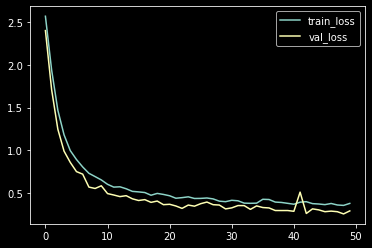

In [59]:
import matplotlib.pyplot as plt
tl = []
vl = []
for x in train_loss:
    tl.append(x.cpu().data)
for x in valid_loss:
    vl.append(x.cpu().data)
plt.plot(tl, label='train_loss')
plt.plot(vl, label='val_loss')
plt.legend()
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

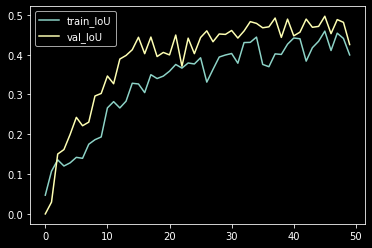

In [60]:
plt.plot(train_IoU, label='train_IoU')
plt.plot(valid_IoU, label='val_IoU')
plt.legend()
plt.show

## Visualize the models output on 4 of target images (5%)

Run the model on 4 samples from the target set. Visualize the outcome by plotting the groud-truth labels, model's predicition, and the difference between them.

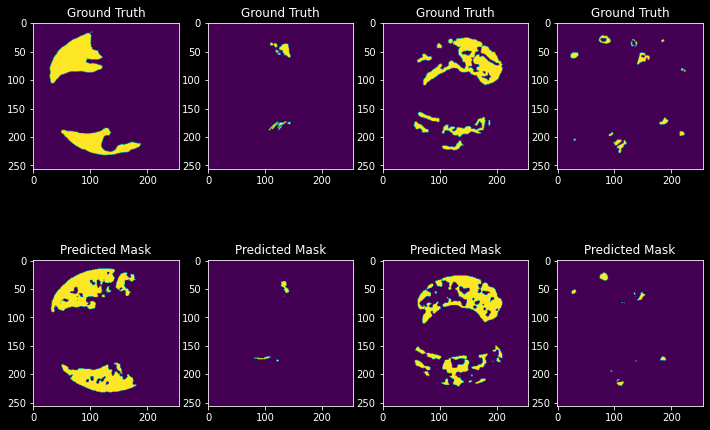

In [62]:
i = 0
fig, axis = plt.subplots(2, 4, figsize=(12,8))
test_loader = DataLoader(test_dataset, batch_size = 1, shuffle = True)
for image, mask in test_loader:
    if i==4:
        break
    axis[0,i].imshow(mask[-1][CLASS])
    axis[0,i].set_title('Ground Truth')
    image = image.to(device)
    mask = mask.to(device)
    pred_mask = model(image)
    pred_mask = pred_mask.detach().cpu().numpy()
    pred_mask = (pred_mask > 0.5)
    axis[1,i].imshow(pred_mask[-1][0])
    axis[1,i].set_title('Predicted Mask')
    i+=1

plt.show()

## Improve U-Net (Bonus) (10%)

In this bnous part, you can add your ideas for improving your model's performance. As an idea, you can search about exploiting IOU metric in the loss function. (you may use other ideas as well!) 

In [ ]:
# TODO: Improve U-NET